# Instalar dependencias e importar paquetes

In [1]:
pip install -U googlemaps

In [2]:
import googlemaps
import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import AntColony as AC
from itertools import tee
import requests
import json
import time

# Introducir la llave para tener acceso a la API de Google

In [3]:
gmaps = googlemaps.Client(key='YOUR API KEY')

# Buscar los lugares de interés

In [4]:

query_result = []
params = {}
place = "sushi"

loc = place+"+en+aguascalientes"
endpoint_url = "https://maps.googleapis.com/maps/api/place/textsearch/json?query="+loc+"&location=21.8828836,-102.2956243&radius=10&key=YOUR API KEY"
         
res = requests.get(endpoint_url, params = params)
results =  json.loads(res.content)
query_result.extend(results['results'])
time.sleep(2)
while "next_page_token" in results:
     params['pagetoken'] = results['next_page_token'],
     res = requests.get(endpoint_url, params = params)
     results = json.loads(res.content)
     query_result.extend(results['results'])
     time.sleep(2)



In [5]:
'''
geocode_result = gmaps.places('sushi en aguascalientes',location=[21.8828836,-102.2956243],radius=100)
time.sleep(2)
while "next_page_token" in results:
  print('hola')
  time.sleep(2)
'''
quantity_of_results = 26

nResults = len(query_result)


lts = np.zeros(nResults)
lgs = np.zeros(nResults)
lcs = []


for i in range(nResults):
  latitude = query_result[i]['geometry']['location']['lat']
  longitud = query_result[i]['geometry']['location']['lng'] 
  location = query_result[i]['formatted_address']

  lts[i] = latitude
  lgs[i] = longitud
  lcs.append(location)

lcs = np.array(lcs)
indexes = np.unique(lcs,return_index=True)[1]
lts = lts[indexes]
lgs = lgs[indexes]
lcs = lcs[indexes]

lts = lts[0:quantity_of_results]
lgs = lgs[0:quantity_of_results]
lcs = lcs[0:quantity_of_results]

nResults = len(lts)
print(nResults)
print(lcs)

id = np.arange(nResults)

output = pd.DataFrame(list(zip(id,lts,lgs,lcs)),columns =['ID','latitude','longitude','location'])
output.to_excel(place+'_coordinates.xlsx')


26
['2 Calle, Av. Paulino N Martí 604, Villa Teresa, 20126 Aguascalientes, Ags., Mexico'
 '2, Av Aguascalientes Sur 101, Versalles 1ra Secc, 20285 Aguascalientes, Ags., Mexico'
 '20240, Av. José María Chávez 512, Barrio del Encino, 20240 Aguascalientes, Ags., Mexico'
 'AGS 95 124, San Cayetano, 20010 Aguascalientes, Ags., Mexico'
 'Andes Apeninos 1201 B, Los Bosques, 20127 Aguascalientes, Ags., Mexico'
 'Aquiles Serdán 409, San Pablo, 20050 Aguascalientes, Ags., Mexico'
 'Av Aguascalientes Nte, Av Independencia esquina, Pulgas Pandas, 20138 Aguascalientes, Ags., Mexico'
 'Av Aguascalientes Sur 1302-Int 15, Casa Blanca, 20266 Aguascalientes, Ags., Mexico'
 'Av Aguascalientes Sur 609-Local 9, Jardines de las Fuentes, 20278 Aguascalientes, Ags., Mexico'
 'Av Aguascalientes Sur 610-6, Jardines de las Fuentes, 20278 Aguascalientes, Ags., Mexico'
 'Av Arqueros 502, Vista del Sol I, 20264 Aguascalientes, Ags., Mexico'
 'Av Canal Interceptor 213, Fraccionamiento Lomas de Santa Anita, 20230 Agu

# Crear un .xlsx para uso posterior de los datos

In [6]:
df = pd.read_excel(place+'_coordinates.xlsx')
longitudes = df['longitude'].values
latitudes = df['latitude'].values 
points = np.zeros((len(longitudes),2))
points[:,0] = latitudes
points[:,1] = longitudes

In [7]:
points

array([[  21.9209211, -102.2812674],
       [  21.8586842, -102.3066567],
       [  21.8755223, -102.294827 ],
       [  21.8986501, -102.3057001],
       [  21.9189973, -102.3144922],
       [  21.8925555, -102.3012176],
       [  21.9153654, -102.298122 ],
       [  21.8598   , -102.2733499],
       [  21.8593136, -102.2887743],
       [  21.8593242, -102.2885875],
       [  21.8621967, -102.2692497],
       [  21.8912997, -102.2730558],
       [  21.8575047, -102.2695592],
       [  21.8816019, -102.2823427],
       [  21.902657 , -102.2888855],
       [  21.8778713, -102.2737712],
       [  21.850021 , -102.29341  ],
       [  21.8663208, -102.2863589],
       [  21.8653375, -102.2916549],
       [  21.8652909, -102.2916335],
       [  21.8771785, -102.3179813],
       [  21.882005 , -102.318176 ],
       [  21.8742485, -102.2707519],
       [  21.8819002, -102.290646 ],
       [  21.8837778, -102.2859898],
       [  21.8892138, -102.2460977]])

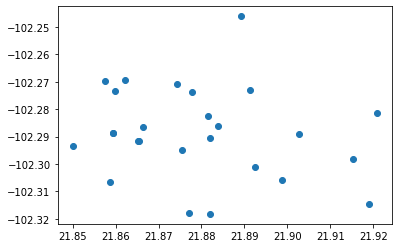

In [8]:
plt.figure() 
plt.scatter(latitudes,longitudes) 
plt.show() 

# Crear la matriz de tiempo y distancia

In [9]:
n = len(longitudes)
dis_mat = np.zeros((n,n))
time_mat = np.zeros((n,n))
time_list = []
distance_list = []
origin_id_list = []
destination_id_list = []

for (i1, row1) in df.iterrows():
  LatOrigin = row1['latitude']
  LongOrigin = row1['longitude']
  origin = (LatOrigin, LongOrigin)
  origin_id = row1['location'] 
  for (i2, row2) in  df.iterrows():
    LatDestination = row2['latitude']
    LongDestination = row2['longitude']
    destination_id = row2['location']
    destination = (LatDestination, LongDestination)
    result = gmaps.distance_matrix(origin, destination, mode = 'driving')
    result_distance = result["rows"][0]["elements"][0]["distance"]["value"]
    result_time = result["rows"][0]["elements"][0]["duration"]["value"]
    if i1!=i2 and result_distance == 0 or i1!=i2 and result_time == 0:
      dis_mat[i1][i2] = 1
      time_mat[i1][i2] = 1
    else:  
      dis_mat[i1][i2] = result_distance
      time_mat[i1][i2] = result_time

    time_list.append(result_time)
    distance_list.append(result_distance)
    origin_id_list.append(origin_id)
    destination_id_list.append(destination_id)

#output = pd.DataFrame(list(zip(origin_id_list,destination_id_list,distance_list,time_list)),columns =['origin','destination','distance(m)','times(s)'])
#output.to_excel('cenadurias_distancematrix.xlsx')
dmExcel = pd.DataFrame(dis_mat,columns=[lcs])
dmExcel = dmExcel.set_index(lcs)
dmExcel.to_excel(place+'_distancematrix.xlsx')
dmExcel = pd.DataFrame(time_mat,columns=[lcs])
dmExcel = dmExcel.set_index(lcs)
dmExcel.to_excel(place+'_timematrix.xlsx')

# Correr la Colonia de hormigas con la matriz de tiempo, distancia y tiempo-distancia

I:  0


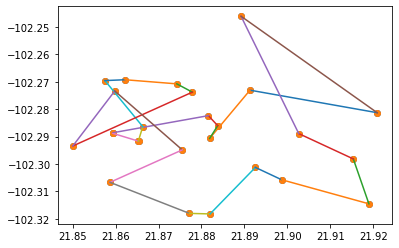

69641.0
I:  1


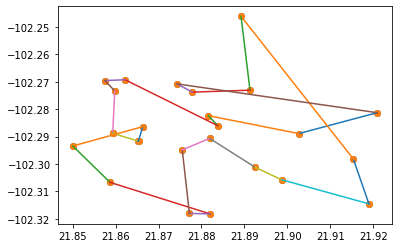

65048.0
I:  2


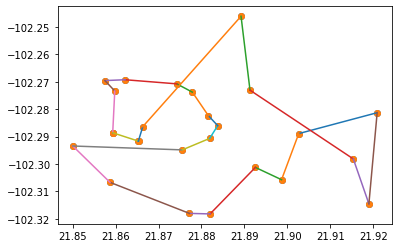

64276.0
I:  2


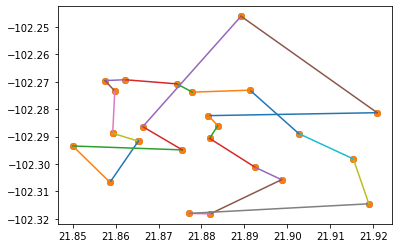

62684.0
I:  3


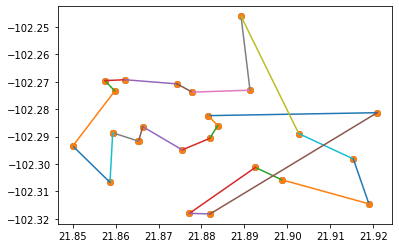

62565.0
I:  3


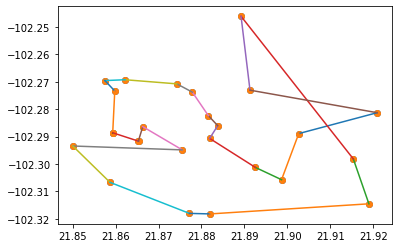

62241.0
I:  4


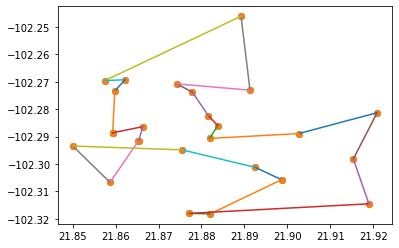

61567.0
I:  5


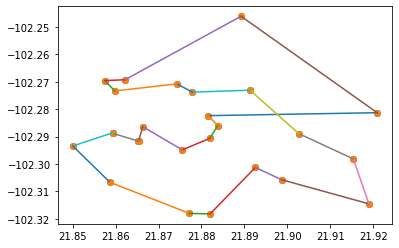

60380.0
I:  6


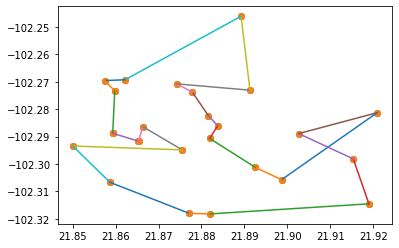

59869.0
I:  14


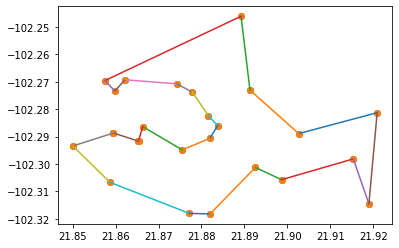

59431.0
I:  23


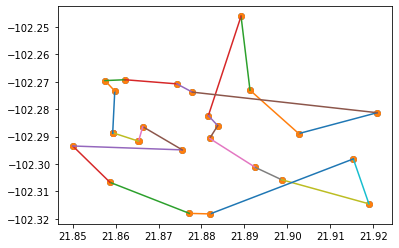

59383.0
I:  28


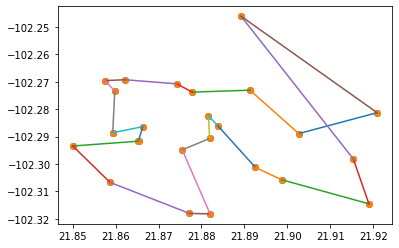

59350.0
I:  31


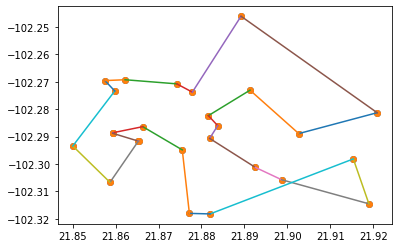

57865.0
I:  65


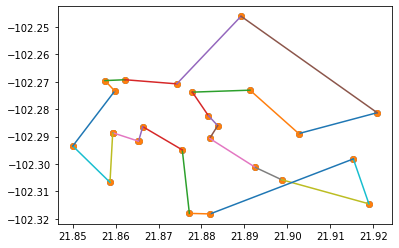

57326.0
TOTAL DISTANCE:  57326.0
TOTAL TIME:  8996.0


In [20]:
res = AC.ant_colony(n,2000,latitudes,longitudes,dis_mat,Ro=0.1,early_stopping_generations=1000)
route = res[0]
total_distance = res[1]
total_time = AC.get_distance(route,time_mat)
print("TOTAL DISTANCE: ",total_distance)
print("TOTAL TIME: ",total_time)

# Función para generar los mapas de google

In [21]:
def generate_maps(origin,destination,waypoints,filename):
  results = gmaps.directions(origin = originR,
                                         destination = destinationR,                                     
                                         waypoints = waypointsR,
                                         optimize_waypoints = False)
  marker_points = []
  waypoints = []

  #extract the location points from the previous directions function

  for leg in results[0]["legs"]:
      leg_start_loc = leg["start_location"]
      marker_points.append(f'{leg_start_loc["lat"]},{leg_start_loc["lng"]}')
      for step in leg["steps"]:
          end_loc = step["end_location"]
          waypoints.append(f'{end_loc["lat"]},{end_loc["lng"]}')
  last_stop = results[0]["legs"][-1]["end_location"]
  marker_points.append(f'{last_stop["lat"]},{last_stop["lng"]}')
          
  markers = [ "color:blue|size:mid|label:" + chr(65+i) + "|" 
            + r for i, r in enumerate(marker_points)]
  result_map = gmaps.static_map(
                  center = [21.8828836,-102.2956243],#coordenadas del centro de aguas
                  scale=2, 
                  zoom=12,
                  size=[1280, 1280], 
                  format="jpg", 
                  maptype="roadmap",
                  markers=markers,
                  path="color:0x0000ff|weight:2|" + "|".join(waypoints))

  with open(filename+"_route_map.png", "wb") as img:
      for chunk in result_map:
          img.write(chunk)
  
  result_map = gmaps.static_map(
                 center=[21.8828836,-102.2956243],
                 scale=2, 
                 zoom=12,
                 size=[640, 640], 
                 format="jpg", 
                 maptype="roadmap",
                 markers=markers,
                 path="color:0x0000ff|weight:2|" + "|".join(marker_points))


  with open(filename+"_map.png", "wb") as img:
      for chunk in result_map:
          img.write(chunk)
    

In [22]:
points = points[route] 
lcs = np.array(lcs)
finalRoute = list(lcs[route])
originR = finalRoute[0]
destinationR = finalRoute[0]
waypointsR = finalRoute[1:]
filename = place+"_distance"
generate_maps(originR,destinationR,waypointsR,filename)

I:  0


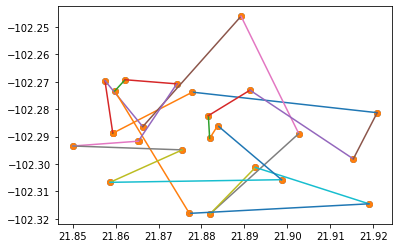

12932.0
I:  0


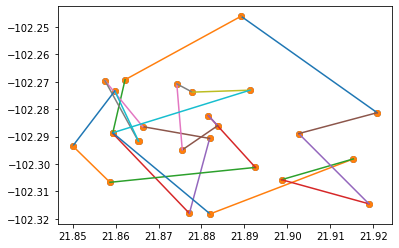

12469.0
I:  0


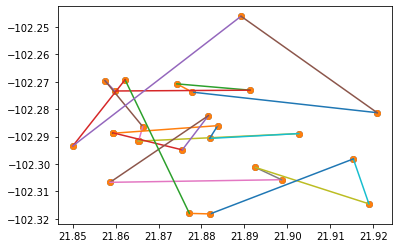

12407.0
I:  0


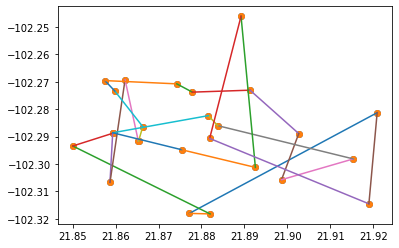

12280.0
I:  0


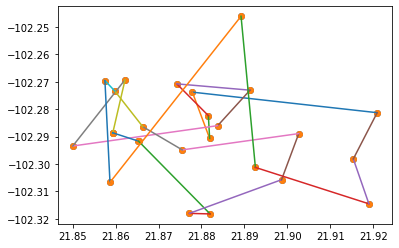

12229.0
I:  0


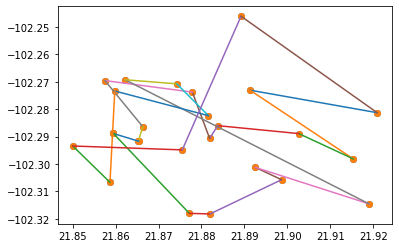

11698.0
I:  0


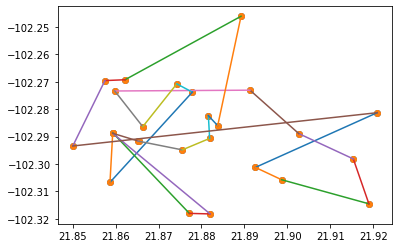

10989.0
I:  1


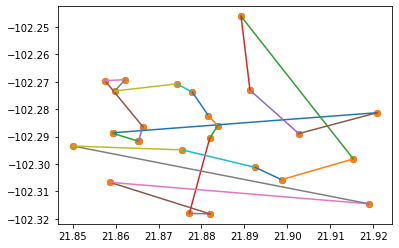

10673.0
I:  1


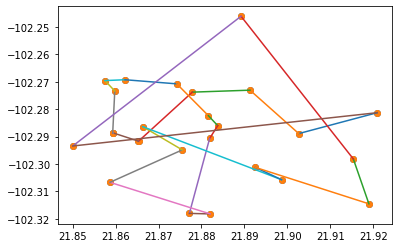

10620.0
I:  1


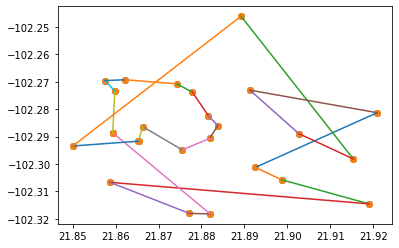

9866.0
I:  1


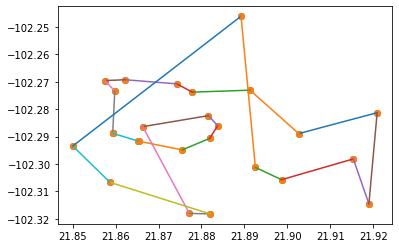

9819.0
I:  3


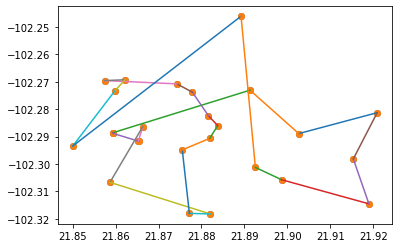

9725.0
I:  3


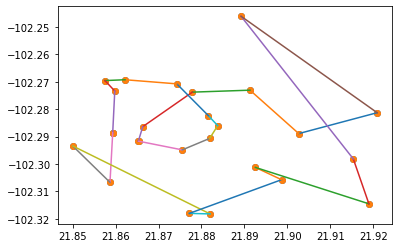

9511.0
I:  4


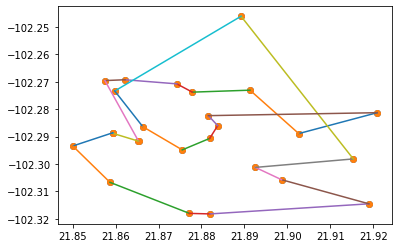

9476.0
I:  5


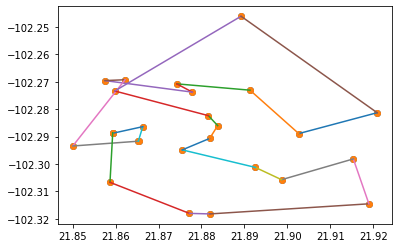

9233.0
I:  8


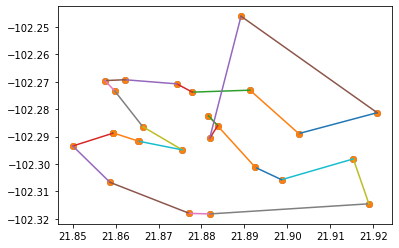

8971.0
I:  10


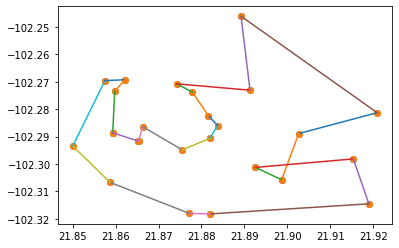

8715.0
I:  54


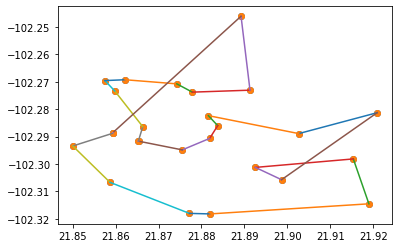

8646.0
TOTAL TIME:  8646.0
TOTAL DISTANCE:  61001.0


In [23]:
res = AC.ant_colony(n,2000,latitudes,longitudes,time_mat,Ro=0.1,early_stopping_generations=1000)
route = res[0]
total_time = res[1]
total_distance = AC.get_distance(route,dis_mat)
print("TOTAL TIME: ",total_time)
print("TOTAL DISTANCE: ",total_distance)  

In [24]:
points = points[route] 
lcs = np.array(lcs)
finalRoute = list(lcs[route])
originR = finalRoute[0]
destinationR = finalRoute[0]
waypointsR = finalRoute[1:]
filename = place+"_time"
generate_maps(originR,destinationR,waypointsR,filename)

In [25]:
maxDist = np.argmax(dis_mat)
nDisMat = dis_mat/maxDist

maxTime = np.argmax(time_mat)
nTimeMat = time_mat/maxTime

average_mat = (nDisMat + nTimeMat)/2

I:  0


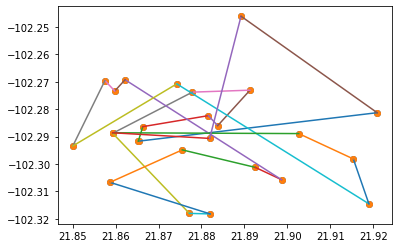

121.58051733499694
I:  0


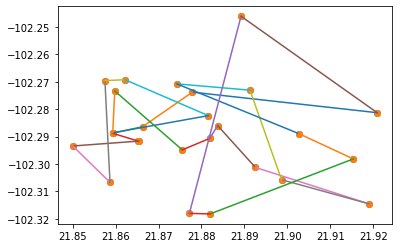

113.92476807726523
I:  0


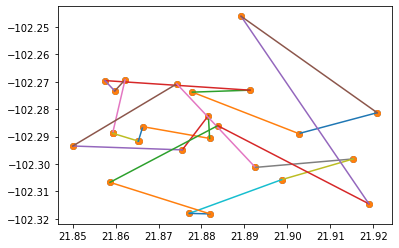

111.76219688305085
I:  1


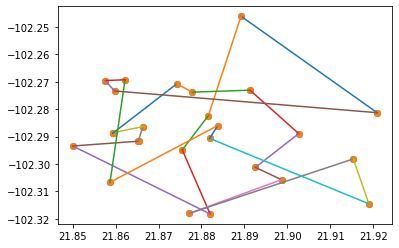

111.09249760279116
I:  1


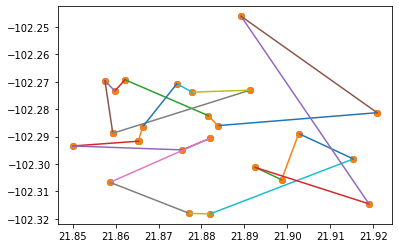

101.19660578333854
I:  1


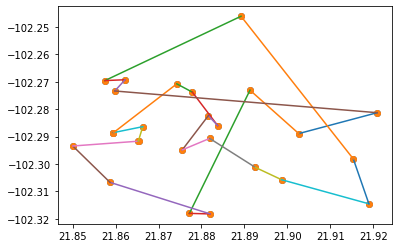

95.45224644462158
I:  1


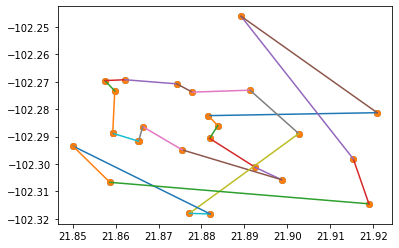

93.8563754202336
I:  1


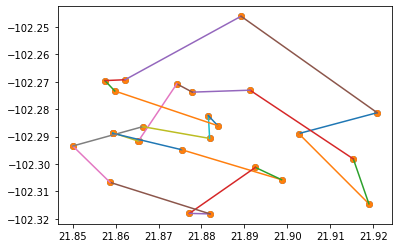

92.03860950334453
I:  2


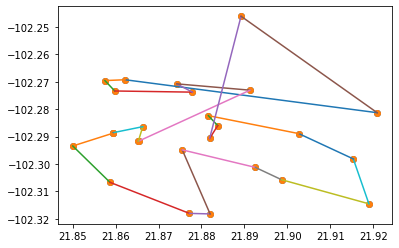

86.42113471736042
I:  3


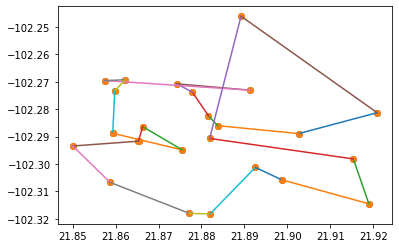

85.20917524463083
I:  3


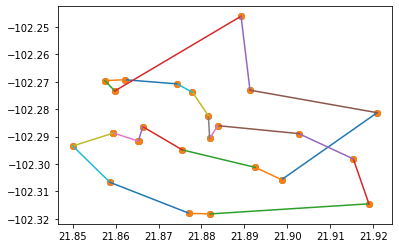

79.56840420984531
I:  11


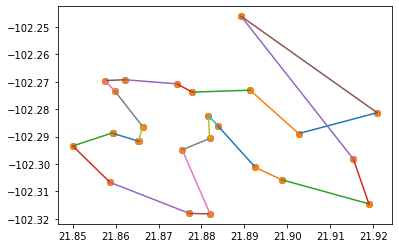

78.3300003465844
I:  13


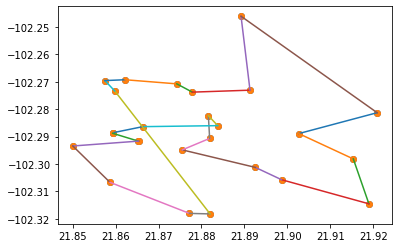

77.52353885788882
I:  58


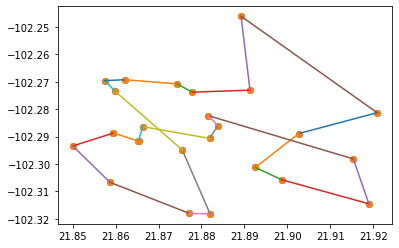

77.21422960061922
I:  70


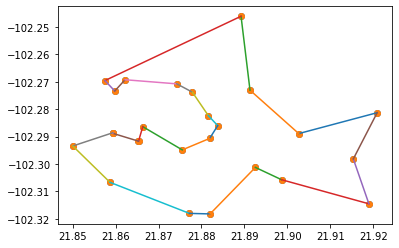

76.10833073395027
TOTAL TIME:  8630.0
TOTAL DISTANCE:  57248.0


In [26]:
res = AC.ant_colony(n,2000,latitudes,longitudes,average_mat,Ro=0.1,early_stopping_generations=1000)
route = res[0]
total_time = AC.get_distance(route,time_mat)
total_distance = AC.get_distance(route,dis_mat)
print("TOTAL TIME: ",total_time)
print("TOTAL DISTANCE: ",total_distance)  

In [27]:
points = points[route] 
lcs = np.array(lcs)
finalRoute = list(lcs[route])
originR = finalRoute[0]
destinationR = finalRoute[0]
waypointsR = finalRoute[1:]
filename = place+"_timedistance"
generate_maps(originR,destinationR,waypointsR,filename)

In [28]:
'''
points = points[route] 
lcs = np.array(lcs)
finalRoute = list(lcs[route])
originR = finalRoute[0]
destinationR = finalRoute[25]
waypointsR = finalRoute[1:25]
filename = place+"_timedistance_part1"
generate_maps(originR,destinationR,waypointsR,filename)

originR = finalRoute[25]
destinationR = finalRoute[0]
waypointsR = finalRoute[26:]
filename = place+"_timedistance_part2"
generate_maps(originR,destinationR,waypointsR,filename)
'''

'\npoints = points[route] \nlcs = np.array(lcs)\nfinalRoute = list(lcs[route])\noriginR = finalRoute[0]\ndestinationR = finalRoute[25]\nwaypointsR = finalRoute[1:25]\nfilename = place+"_timedistance_part1"\ngenerate_maps(originR,destinationR,waypointsR,filename)\n\noriginR = finalRoute[25]\ndestinationR = finalRoute[0]\nwaypointsR = finalRoute[26:]\nfilename = place+"_timedistance_part2"\ngenerate_maps(originR,destinationR,waypointsR,filename)\n'